In [1]:
!python -m spacy download el_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('el_core_news_sm')


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import pandas as pd
%matplotlib inline
import numpy as np
import glob
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime

# Διαβάζουμε το EmoLex



In [4]:
filepath = "https://raw.githubusercontent.com/datajour-gr/Data_journalism/master/week10/NRC_GREEK_Translated_6_2020.csv"
emolex_df = pd.read_csv(filepath)
emolex_df.head()

,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,αφεση,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ενορκη βεβαιωση,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,εχοντας,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,εχω,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,οριο,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
emolex_df.tail()

,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
13166,ουρλιασμα,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
13167,κροκος αυγου,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13168,νεοτερος,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13169,ζεφυρος,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13170,ζουμ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
emolex_df = emolex_df.drop_duplicates(subset=['word'])
emolex_df = emolex_df.dropna()
emolex_df.reset_index(inplace = True)

In [7]:
emolex_df.tail()

,index,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
13156,13166,ουρλιασμα,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
13157,13167,κροκος αυγου,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13158,13168,νεοτερος,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13159,13169,ζεφυρος,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13160,13170,ζουμ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
import spacy
nlp = spacy.load('el_core_news_sm')

## Διαβάζουμε τα tweets



In [9]:
full_tweets_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/visitgreece_search.tsv", sep='\t')

In [10]:
len(full_tweets_df)

673

In [11]:
short_tweets = full_tweets_df[['created_at','text' ]]
short_tweets = short_tweets.rename(columns={'created_at': 'date', 'text': 'text'} )

In [12]:
short_tweets.tail()

,date,text
668,Tue Jun 22 07:38:35 +0000 2021,The port of Alonissos at night! Time for a wal...
669,Tue Jun 22 07:10:59 +0000 2021,#lightsofmykonos #view #jmk\n\n#mykonos #mikon...
670,Tue Jun 22 07:04:57 +0000 2021,He needs to make his house in Greece covid-saf...
671,Tue Jun 22 06:56:27 +0000 2021,RT @VisitGreecegr: We have an announcement to ...
672,Tue Jun 22 06:11:19 +0000 2021,"“If California were an island, it would be Cre..."


In [13]:
short_tweets.dtypes

date    object
text    object
dtype: object

In [14]:
short_tweets['date'] = pd.to_datetime(short_tweets['date'], format='%a %b %d %H:%M:%S +0000 %Y')


In [15]:
short_tweets.dtypes

date    datetime64[ns]
text            object
dtype: object

In [16]:
emolex_df['word'].head(3)

0              αφεση
1    ενορκη βεβαιωση
2            εχοντας
Name: word, dtype: object

In [17]:
short_tweets['text'] = short_tweets['text'].str.replace(r'https?:\/\/.*[\r\n]*'," ")

In [18]:
short_tweets.head()

,date,text
0,2021-06-30 13:15:33,Experience Kimolos with Aria Hotels! \nEnjoy t...
1,2021-06-30 12:30:12,"RT @WindyCityGreek: Visiting Veria, Greece’s b..."
2,2021-06-30 12:21:21,RT @Darmand15766004: #visitGreece #symi
3,2021-06-30 12:21:18,RT @Darmand15766004: #visitGreece #rodos
4,2021-06-30 12:19:15,#visitGreece #rodos


In [19]:
short_tweets.head()

,date,text
0,2021-06-30 13:15:33,Experience Kimolos with Aria Hotels! \nEnjoy t...
1,2021-06-30 12:30:12,"RT @WindyCityGreek: Visiting Veria, Greece’s b..."
2,2021-06-30 12:21:21,RT @Darmand15766004: #visitGreece #symi
3,2021-06-30 12:21:18,RT @Darmand15766004: #visitGreece #rodos
4,2021-06-30 12:19:15,#visitGreece #rodos


In [20]:
vec = CountVectorizer(analyzer = 'word', vocabulary = emolex_df.word, 
                      strip_accents = 'unicode',  
                      stop_words= nlp.Defaults.stop_words,
                      ngram_range=(1, 2))

In [21]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#CountVectorizer(stop_words='english', binary=True)
# Θέλω να ελέγξω μόνο τις λέξεις που υπάρχουν στο συναισθηματικό λεξικό

#CountVectorizer(analyzer = 'word', 
#                strip_accents = 'unicode', 
#                token_pattern='[Α-Ωα-ωΆ-Ώά-ώ]{2,}', 
#                stop_words= lc_stop_words_df['stop_w'].tolist())


matrix = vec.fit_transform(short_tweets['text'])
vocab = vec.get_feature_names()
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wordcount_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['αδιακοπα', 'ακομα', 'ακομη', 'ακριβως', 'αλλα', 'αλλαχου', 'αλλες', 'αλλη', 'αλλην', 'αλλης', 'αλλιως', 'αλλιωτικα', 'αλλο', 'αλλοι', 'αλλοιως', 'αλλοιωτικα', 'αλλον', 'αλλος', 'αλλοτε', 'αλλου', 'αλλους', 'αλλων', 'αμα', 'αμεσα', 'αμεσως', 'ανα', 'αναμεσα', 'αναμεταξυ', 'ανευ', 'αντι', 'αντιπερα', 'αντις', 'ανω', 'ανωτερω', 'αξαφνα', 'απεναντι', 'απο', 'αποψε', 'αρα', 'αραγε', 'αρκετα', 'αρκετες', 'αρχικα', 'αυριο', 'αυτα', 'αυτες', 'αυτη', 'αυτην', 'αυτης', 'αυτο', 'αυτοι', 'αυτον', 'αυτος', 'αυτου', 'αυτους', 'αυτων', 'αφοτου', 'αφου', 'βεβαια', 'βεβαιοτατα', 'γιατι', 'γρηγορα', 'γυρω', 'δεινα', 'δεξια', 'δηθεν', 'δηλαδη', 'διαρκως', 'δικα', 'δικο', 'δικοι', 'δικος', 'δικου', 'δικους', 'διολου', 'διπλα', 'διχως', 'εαν', 'εαυτο', 'εαυτον', 'εαυτου', 'εαυτους', 'εαυτων', 'εγιναν', 'εγινε', 

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,αυτοκινητοδρομος,αυγουστος,βερολινο,βικτωρια,βοστωνη,γαμηλιο ταξιδι,γεννηση παιδιου,γαιδαρος,γατα,γερμανος,γιαννης,γνωστοποιηση,γυαλια,διακοπη,διευθυντρια σχολειου,διδυμοι,δεξαμενη,δευτερα παρουσια,δευτερον,δημοκρατια,διαρκεια ζωης,διαδρομη,διαλογισμος,διεθνες,διευθυνσεις,δραμα,εξαρτηση,εξωτερικου χωρου,επικοινωνω,επιπτωσεις,...,καρυδια,ωχρος,ελλειπων,προϊοντα,δικαιολογημενο,ενταλματα,κρεατοελλια,αποτυχημενος,σπαταλω,τροποι,ξεπερασμενο,αδιαβροχος,παντρευομαι,βοτανισμα,χωρις βαρος,παραξενα,καλωσορισατε,κρασπεδο,χελωνι,ηχηρο κτυπημα,απολυτως,πλατυς,ανθρωπινο ον,ανεξελεγκτη πυρκαγια,απροσδοκητα ευρημα,μαραμενο,αλιμονο,επιδεινωνεται,αποσπω βιαια,καρπος του χεριου,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
wordcount_df.shape

(673, 13161)

In [23]:
emolex_df.head()

,index,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,0,αφεση,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,ενορκη βεβαιωση,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,εχοντας,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,εχω,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,οριο,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
emolex_df[emolex_df.Anger == 1].tail()

,index,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
13094,13104,διεξοδος,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13096,13106,ζωυφια,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
13100,13110,θυματοποιω,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
13128,13138,αποτυχημενος,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
13156,13166,ουρλιασμα,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [25]:
# Φτιάξε μια λίστα με positive words

angry_words = emolex_df[emolex_df.Anger == 1]['word']

positive_words = emolex_df[emolex_df.Positive == 1]['word']


# Φτιάξε μια λίστα με sadness words
sadness_words = emolex_df[emolex_df.Sadness == 1]['word']


# Φτιάξε μια λίστα με surprise words
surprise_words = emolex_df[emolex_df.Surprise == 1]['word']


# Φτιάξε μια λίστα με disgust words
disgust_words = emolex_df[emolex_df.Disgust == 1]['word']


# Φτιάξε μια λίστα με anticipation words
anticipation_words = emolex_df[emolex_df.Anticipation == 1]['word']


# Φτιάξε μια λίστα με negative words
negative_words = emolex_df[emolex_df.Negative == 1]['word']



# Φτιάξε μια λίστα με joy words
joy_words = emolex_df[emolex_df.Joy == 1]['word']


# Φτιάξε μια λίστα με trust words
trust_words = emolex_df[emolex_df.Trust == 1]['word']



# Φτιάξε μια λίστα με fear words
fear_words = emolex_df[emolex_df.Fear == 1]['word']




In [26]:
short_tweets.head(3)

,date,text
0,2021-06-30 13:15:33,Experience Kimolos with Aria Hotels! \nEnjoy t...
1,2021-06-30 12:30:12,"RT @WindyCityGreek: Visiting Veria, Greece’s b..."
2,2021-06-30 12:21:21,RT @Darmand15766004: #visitGreece #symi


In [27]:
short_tweets['anger'] = wordcount_df[angry_words].sum(axis=1)

short_tweets['positivity'] = wordcount_df[positive_words].sum(axis=1)


short_tweets['joy'] = wordcount_df[joy_words].sum(axis=1)


short_tweets['disgust'] = wordcount_df[disgust_words].sum(axis=1)



short_tweets['surprise'] = wordcount_df[surprise_words].sum(axis=1)

short_tweets['trust'] = wordcount_df[trust_words].sum(axis=1)


short_tweets['anticipation'] = wordcount_df[anticipation_words].sum(axis=1)


short_tweets['sadness'] = wordcount_df[sadness_words].sum(axis=1)

short_tweets['negative'] = wordcount_df[negative_words].sum(axis=1)

short_tweets['fear'] = wordcount_df[fear_words].sum(axis=1)




In [28]:
short_tweets

,date,text,anger,positivity,joy,disgust,surprise,trust,anticipation,sadness,negative,fear
0,2021-06-30 13:15:33,Experience Kimolos with Aria Hotels! \nEnjoy t...,0,0,0,0,0,0,0,0,0,0
1,2021-06-30 12:30:12,"RT @WindyCityGreek: Visiting Veria, Greece’s b...",0,0,0,0,0,0,0,0,0,0
2,2021-06-30 12:21:21,RT @Darmand15766004: #visitGreece #symi,0,0,0,0,0,0,0,0,0,0
3,2021-06-30 12:21:18,RT @Darmand15766004: #visitGreece #rodos,0,0,0,0,0,0,0,0,0,0
4,2021-06-30 12:19:15,#visitGreece #rodos,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
668,2021-06-22 07:38:35,The port of Alonissos at night! Time for a wal...,0,0,0,0,0,0,0,0,0,0
669,2021-06-22 07:10:59,#lightsofmykonos #view #jmk\n\n#mykonos #mikon...,0,0,0,0,0,0,0,0,0,0
670,2021-06-22 07:04:57,He needs to make his house in Greece covid-saf...,0,0,0,0,0,0,0,0,0,0
671,2021-06-22 06:56:27,RT @VisitGreecegr: We have an announcement to ...,0,0,0,0,0,0,0,0,0,0


In [29]:
short_tweets.set_index('date' , inplace=True)

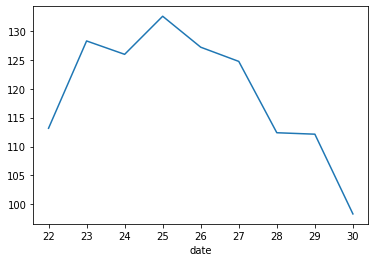

In [30]:
short_tweets['text'].str.len().groupby(by=short_tweets.index.day).mean().plot() 

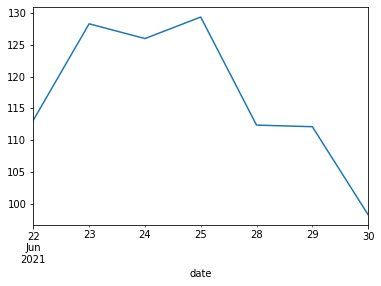

In [31]:
short_tweets['text'].str.len().resample('C').mean().plot() 

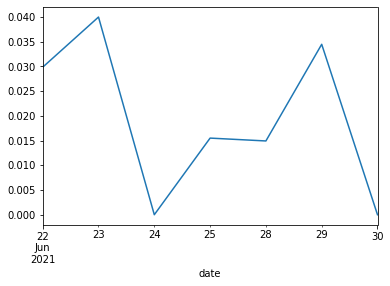

In [32]:
short_tweets['positivity'].resample('C').mean().plot() 

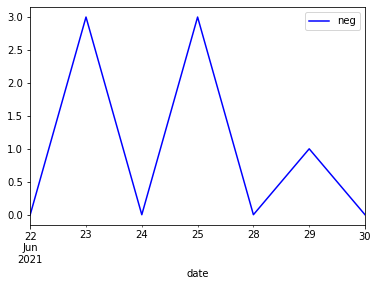

In [33]:
short_tweets['negative'].resample('C').sum().plot(color = 'b',label = 'neg').legend() 

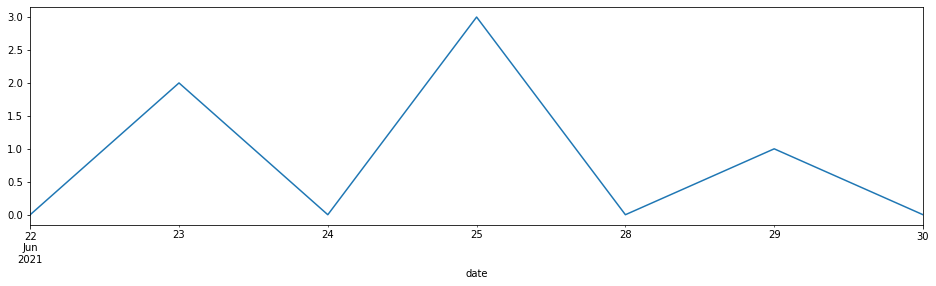

In [34]:
short_tweets['anger'].resample('C').sum().plot(figsize=(16,4))

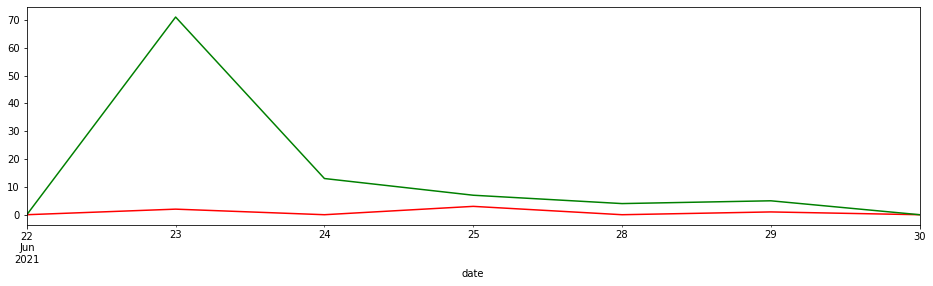

In [35]:
ax = short_tweets['anger'].resample('C').sum().plot(figsize=(16,4), color = 'red')
short_tweets['joy'].resample('C').sum().plot(figsize=(16,4), ax = ax, color = 'green')

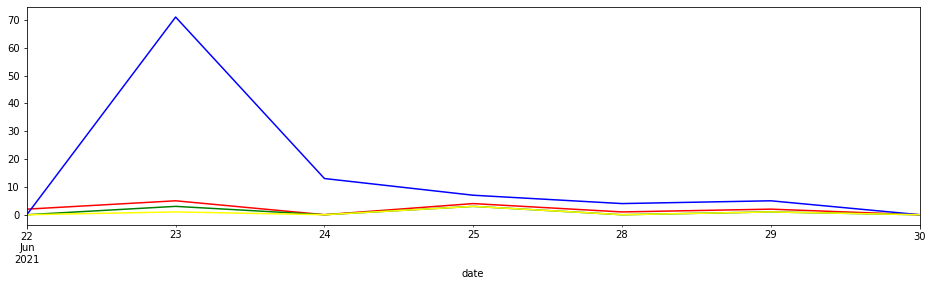

In [36]:
ax = short_tweets['positivity'].resample('C').sum().plot(figsize=(16,4), color = 'red')
short_tweets['negative'].resample('C').sum().plot(figsize=(16,4), ax = ax, color = 'green')
short_tweets['joy'].resample('C').sum().plot(figsize=(16,4), ax = ax, color = 'blue')
short_tweets['fear'].resample('C').sum().plot(figsize=(16,4), ax = ax, color = 'yellow')

In [37]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

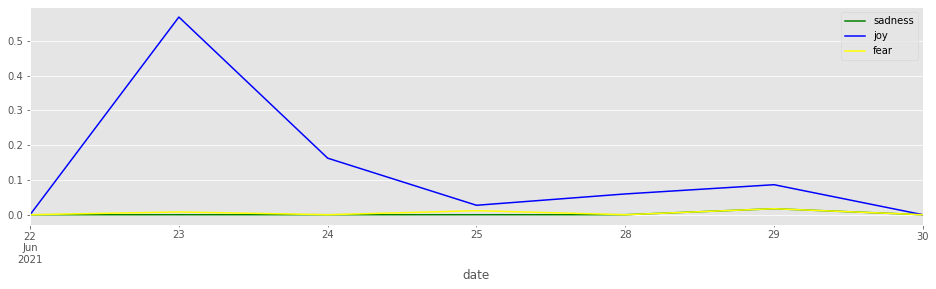

In [41]:
ax = short_tweets['sadness'].resample('C').mean().plot(figsize=(16,4), 
                                                          color = 'g', label='sadness')
short_tweets['joy'].resample('C').mean().plot(figsize=(16,4), ax = ax, 
                                                label = 'joy',color = 'blue')
short_tweets['fear'].resample('C').mean().plot(figsize=(16,4), ax = ax, 
                                                label = 'fear',color = 'yellow').legend()

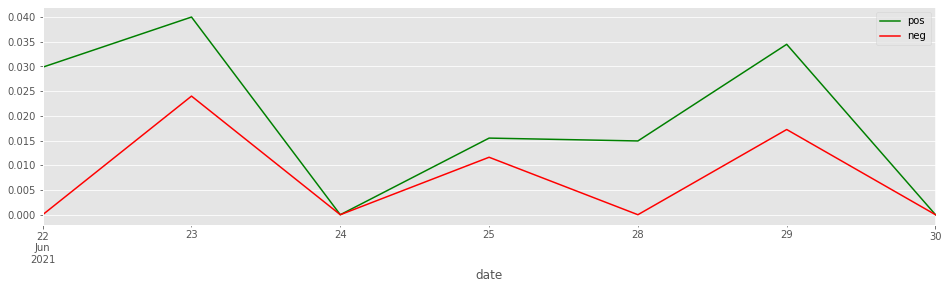

In [40]:
ax = short_tweets['positivity'].resample('C').mean().plot(figsize=(16,4), 
                                                          color = 'g', label='pos')
short_tweets['negative'].resample('C').mean().plot(figsize=(16,4), ax = ax, 
                                                   label = 'neg', color = 'r').legend()